# Gaussian Processes in Julia

We want to use Gaussian processes is because they are useful for regressing over non-linear functions.

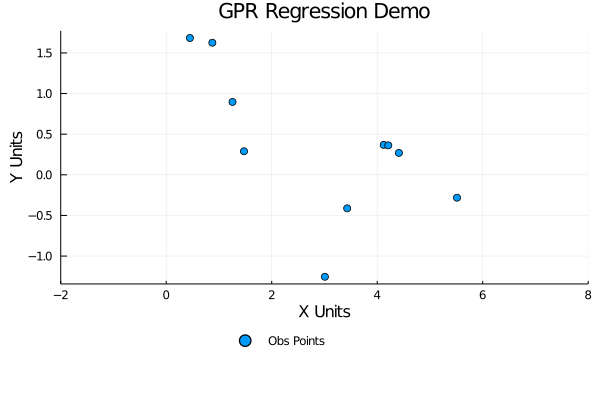

In [1]:
# Observations of the Function
using Random
using Distributions

unknown_function(x) = cos(x)+sin(2*x)

# Choose points to observe (wide area)
x_observe = collect(0.4:0.5:2*pi/1.1)
x_observe = rand(Uniform(0.4, 2*pi/1.1), 10) 
# Assume perfect measurements (for now)
y_observe = unknown_function.(x_observe)
using Plots
scatter(x_observe, y_observe, xlims=(-2, 8), 
        xlabel="X Units", ylabel="Y Units", label="Obs Points", title="GPR Regression Demo", 
        legend=:outerbottom, fg_legend=:transparent) 

## About Gaussian Processes
We will use a Gaussian process regression to try and find this function. But first, what is a Guassian process? Formally,

> A gaussian process is a collection of random variables any finite number of which are Gaussian.

Consider a stochastic process driven by time: $(X_t)_{t\in[0,\dots,\infty]}$. This is a family of random variables. If it so happens that each random variable $X_t$ is Gaussian, then this is a Gaussian process. Choosing one $X_t$ will result in a 1D Gaussian, and a finite number $n$ of them will be an $n$-dimensional multivariate Gaussian. This process need not be indexed by time. **Anything can be an index so long as the indexed random variable is a Gaussian.**

A Gaussian process is completely defined by its mean function $m(i)$ and covariance function $k(i,j)$ (similar to a Gaussian distribution) where $i$ is whatever the index is you're using. Let's consider a simple example:

$$
m(x) = \frac{1}{4}diag(xx') \\
k(x,y) = exp(-\frac{1}{2}(x-y)'(x-y))
$$

Given some vector of indeces to test $X$, we can calculate the Gaussian distribution at each index:
$$
    \mu(X) = m(X)\\~Notation
    \Sigma(X, Y) = Mat(k(X_i, Y_j))~~\forall~i,j\in X\\
    \Sigma(X, y) = Vec(k(X_i, y))~~\forall~i\in X
$$

In [2]:
m(x) = 1/4*x^2
k(x,y) = exp(-1/2*(x-y)'*(x-y)) # Simple Sqare Exponent Kernel (No Hyperparameters)

# Function to calculate the covariance matrix
function calculate_covariance(x1, x2, k_specific)
    n = length(x1)
    m = length(x2)
    C = zeros(n,m)
    for i = 1:n
        for j = 1:m
            C[i, j] = k_specific(x1[i], x2[j]) + 0.01
            C[i, j] = (abs(C[i, j]) < 1e-6) ? 0 : C[i, j]
        end
    end
    return C

end;

## Let's Draw Some Functions From This

Without going into too much detail, the function `sample_gp` effectively samples a function from a Gaussian process from evaluating the mean and covariance functions at different indeces.

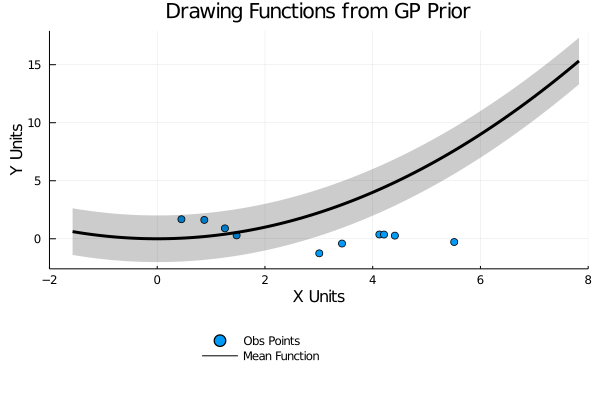

In [3]:
using LinearAlgebra
function sample_gp(mu, sigma)
    u = randn(length(mu))
    U, D, V = svd(sigma)
    L = U*sqrt(diagm(D))
    sampled_points = mu + L*u
    return sampled_points, L
end

# Draw from this Gaussian Process
x_draw = collect(-pi/2:0.1:2.5*pi)
mu = m.(x_draw)
sigma = calculate_covariance(x_draw, x_draw, k)

scatter(x_observe, y_observe, xlims=(-2, 8), 
        xlabel="X Units", ylabel="Y Units", label="Obs Points", 
        legend=:outerbottom, fg_legend=:transparent)
plot!(x_draw, m.(x_draw),  ribbon=2*sqrt.(diag(sigma)), color="black", alpha=1, linewidth=3, label="Mean Function",
     title="Drawing Functions from GP Prior", xlabel="X Units", ylabel="Y Units", fillalpha=0.2)


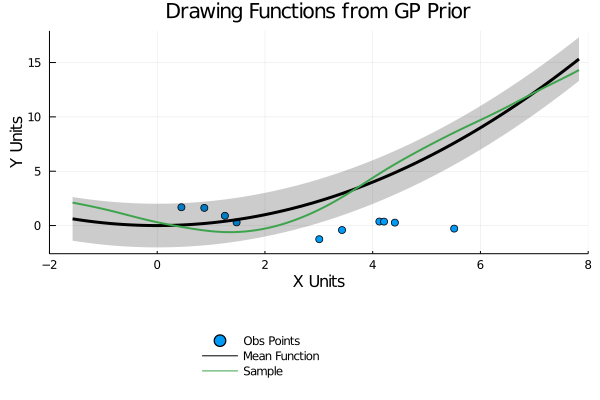

In [4]:
# Draw One Function from the Gaussian Process ...
plot!(x_draw, sample_gp(mu, sigma), label="Sample", linewidth=2)

## Calculating the Conditional Posterior Mean and Variance (Noise-Free)
The basis of regression using Gaussian processes is Baye's rule for conditioning probabilities:

> conditioned probability = likelihood * prior / (normalizing constant)

which is the basis for anything Bayesian (e.g. estimation). Suppose we have a joint distribution between Gaussian random variables. The fundamental equations for conditioning from a joint distribution are

$$m_{2|1} = m_{11} + \Sigma_{21}\Sigma_{22}^{-1}(y - m_{11})\\
\Sigma_{2|1} = \Sigma_{11} - \Sigma_{21}\Sigma_{22}^{-1}\Sigma_{12}$$

These equations work for Gaussian distributions $\mathcal{N}(\mu,~\sigma)$ and Gaussian processes $\mathcal{GP}(m(x),~k(x,x'))$. The new posterior mean and kernel function based on observed data is:
$$
m(x|D) = m(x) + \Sigma(X,x)^T\Sigma(X,X)^{-1}(\mathbf{f} - m(X))\\
k(x,y|D) = k(x,y) - \Sigma(X,x)^T\Sigma(X,X)^{-1}\Sigma(X,y)
$$

Now we can draw functions from the conditioned GP:
$$f|D\sim\mathcal{GP}(m(x|D), k(x,y|D))$$

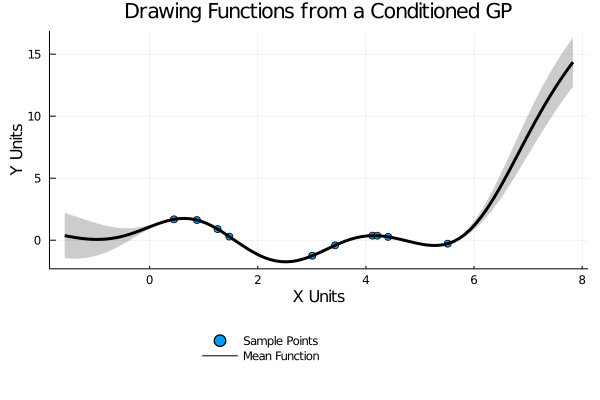

In [5]:
scatter(x_observe, y_observe, label="Sample Points")

# Calculating the Posterior Process
m_posterior(x) = m.(x) + calculate_covariance(x_observe, x, k)'*inv(calculate_covariance(x_observe, x_observe, k))*(y_observe - m.(x_observe))
k_posterior(x, y) = k(x, y) - [calculate_covariance(x_observe, x, k)'*inv(calculate_covariance(x_observe, x_observe, k))*calculate_covariance(x_observe, y, k)][1][1]

mu = m_posterior(x_draw)
sigma = calculate_covariance(x_draw, x_draw, k_posterior)

plot!(x_draw, m_posterior(x_draw), ribbon=2*sqrt.(diag(sigma)), color="black", alpha=1, linewidth=3, label="Mean Function",
     title="Drawing Functions from a Conditioned GP", xlabel="X Units", ylabel="Y Units", legend=:outerbottom, fg_legend=:transparent, fillalpha=0.2)


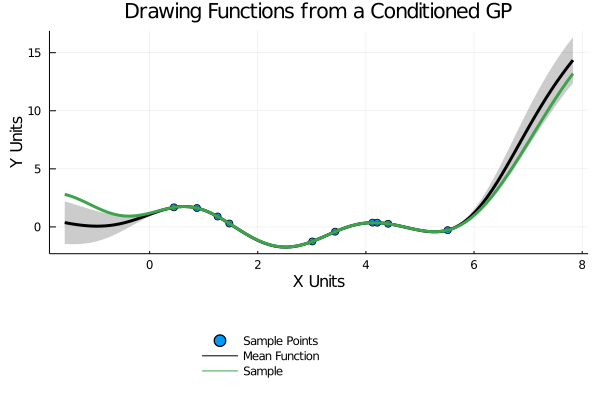

In [6]:
# Draw One Function from the Gaussian Process ...
plot!(x_draw, sample_gp(mu, sigma), label="Sample", linewidth=3, fillalpha=0.2)

## Looks Good! Except, we never have perfect measurments. 

If you have Gaussian noise on your measurements, then it is straightforward to incorporate measurement uncertainty in the conditioning:

$$
y = f(x) +\omega,~\omega\sim\mathcal{N}(0,\sigma_n^2)\\
m(x|D) = m(x) + \Sigma(X,x)^T(\Sigma(X,X)+I\sigma_n^2)^{-1}(\mathbf{f} - m(X))\\
k(x,y|D) = k(x,y) - \Sigma(X,x)^T(\Sigma(X,X)+I\sigma_n^2)^{-1}\Sigma(X,y)
$$

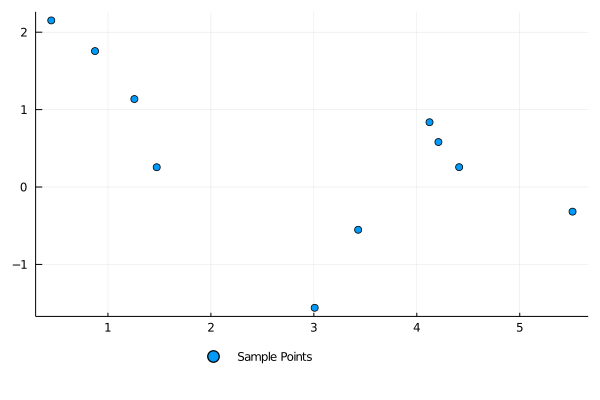

In [7]:
#####
# PART III: Condition on Noisy Observations
#####

# Observations of the Function
noise_variance = 0.3
y_observe_noisy = y_observe + noise_variance*randn(length(x_observe))

scatter(x_observe, y_observe_noisy, label="Sample Points", legend=:outerbottom, fg_legend=:transparent)

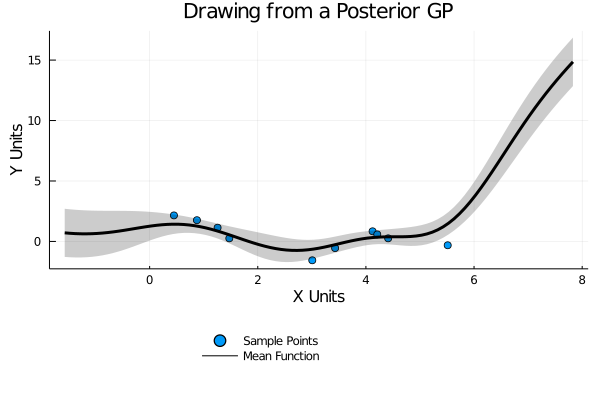

In [8]:
# Calculating the Posterior Process
m_posterior(x) = m.(x) + calculate_covariance(x_observe, x, k)'*inv(calculate_covariance(x_observe, x_observe, k) + I*noise_variance)*(y_observe - m.(x_observe))
k_posterior(x, y) = k(x, y) - [calculate_covariance(x_observe, x, k)'*inv(calculate_covariance(x_observe, x_observe, k) + I*noise_variance)*calculate_covariance(x_observe, y, k)][1][1]

# Calculate the new Gaussian distributions at each trial point
mu = m_posterior(x_draw)
sigma = calculate_covariance(x_draw, x_draw, k_posterior)

plot!(x_draw, m_posterior(x_draw), color="black", ribbon=2*sqrt.(diag(sigma)), alpha=1, linewidth=3, label="Mean Function",
     title="Drawing from a Posterior GP", xlabel="X Units", ylabel="Y Units", fillalpha=0.2)

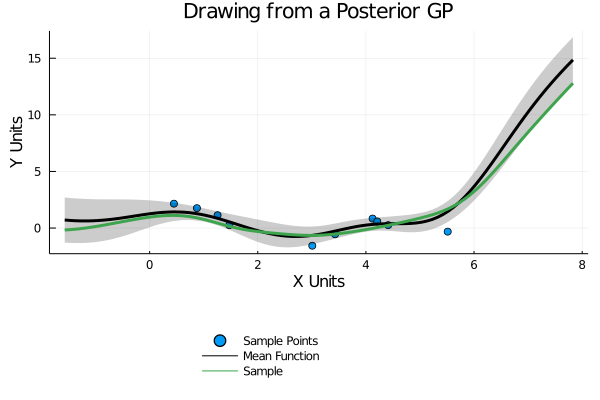

In [9]:
# Draw One Function from the Gaussian Process ...
plot!(x_draw, sample_gp(mu, sigma), linewidth=3, label="Sample")

## So What Does this Mean?

I'm studying literature about how the difference between the true function and the GP regression are related to pull out probabilities. 



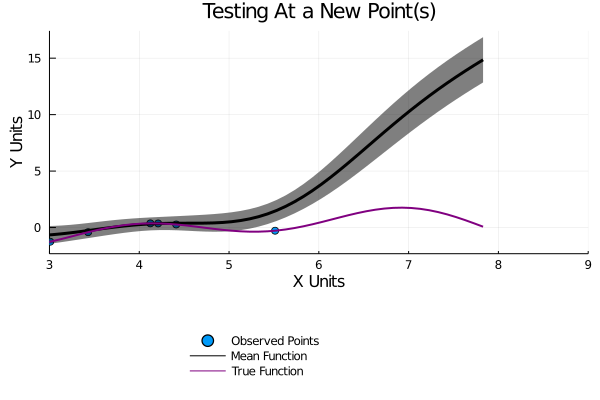

In [10]:
#####
# PART IV: Using this For Predictions
#####

# x_test = collect(1:0.25:2)
x_test = collect(3:0.1:9)
mu = m_posterior(x_test)
sigma = calculate_covariance(x_draw, x_draw, k_posterior)

y_true = unknown_function.(x_draw)

scatter(x_observe, y_observe, label="Observed Points", legend=:outerbottom, fg_legend=:transparent, xlim=(x_test[1], x_test[end]))
plot!(x_draw, m_posterior(x_draw), ribbon=2*sqrt.(diag(sigma)), color="black", alpha=1, linewidth=3, label="Mean Function",
     title="Testing At a New Point(s)", xlabel="X Units", ylabel="Y Units")
# scatter!(x_test, mu, yerror=6*sqrt.(diag(sigma)), label="Prediction Points")
plot!(x_draw, y_true, linewidth=2, color="purple", label="True Function")

## Reconsider the Prior Mean and Covariance Function Choices...

I just arbitrarily chose what the prior mean and covariance functions were. This is clearly having an effect on our regression.

Instead, let's parameterize the prior mean and covariance:

$$ m(x|\theta) = \theta_1 x^2 + \theta_2 x + \theta_3\\
   k(x,y|\gamma) = \gamma_1exp(\gamma_2(x-y)^T(x-y)) + \gamma_3
$$

Given some training data, offline optimization (i.e. gradient descent on parameter likelihood) to find the best hyperparameters to get the tightest fit (then condition on that!).

This notebook does not actually do hyperparameter optimization. Instead, I look at the effects of different prior choices to get a feel.

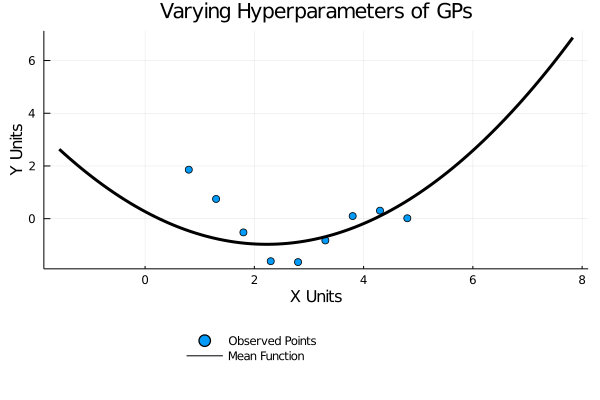

In [11]:
#####
# PART V: Different Hyperparameters?
#####
# m(x) = x
m(x) = 1/4*x^2
# m(x) = 1/4*x^3
# m(x) = sin(x)^2

# Different kernels
# k(x,y) = 1*exp(-1/2*(x-y)'*(x-y)) # Simple Sqare Exponent Kernel (No Hyperparameters)
# k(x,y) = min(abs(x),abs(y)) # Brownian Motion Kernel (No Hyperparameters)
k(x,y) = x'*y

x_observe = collect(0.8:0.5:2*pi/1.2)
noise_variance = 0.1
y_observe = unknown_function.(x_observe) + noise_variance*randn(length(x_observe))
scatter(x_observe, y_observe, label="Observed Points", legend=:outerbottom, fg_legend=:transparent)

# Calculating the Posterior Process
m_posterior(x) = m.(x) + calculate_covariance(x_observe, x, k)'*inv(calculate_covariance(x_observe, x_observe, k) + I*noise_variance)*(y_observe - m.(x_observe))
k_posterior(x, y) = k(x, y) - [calculate_covariance(x_observe, x, k)'*inv(calculate_covariance(x_observe, x_observe, k) + I*noise_variance)*calculate_covariance(x_observe, y, k)][1][1]

# Calculate the new Gaussian distributions at each trial point
mu = m_posterior(x_draw)
sigma = calculate_covariance(x_draw, x_draw, k_posterior)

plot!(x_draw, m_posterior(x_draw), color="black", alpha=1, linewidth=3, label="Mean Function",
     title="Varying Hyperparameters of GPs", xlabel="X Units", ylabel="Y Units")

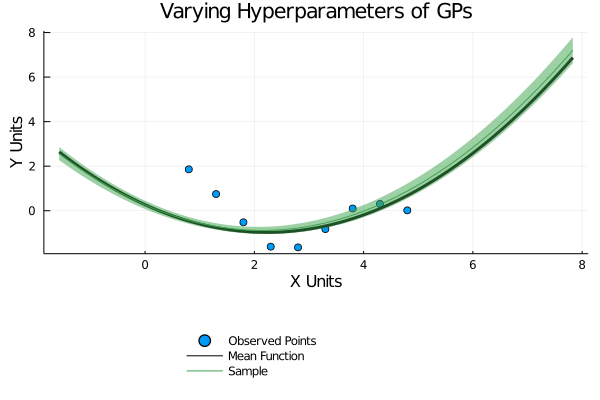

In [12]:
plot!(x_draw, sample_gp(mu, sigma), ribbon=2*sqrt.(diag(sigma)), label="Sample")